In [1]:
%matplotlib inline
import pandas as pd
import re
import os, itertools, csv
import bleach
import progressbar
from bs4 import BeautifulSoup
from datetime import datetime
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier, VotingClassifier, VotingRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from snownlp import SnowNLP
from textblob import TextBlob

In [2]:
df = pd.read_csv('./dataset/train.csv')
print(df.head(5))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


## Data Preprocessing

- two model
    - one is title's word2vec
    - one is other features like datachannel, tag or sth (0.57's model)

In [3]:
def data_preprocess(text):
    bs = BeautifulSoup(text, 'html.parser')
    title = bs.find(class_="title").text
    title_emotion = TextBlob(title).sentences[0].sentiment.polarity
    content = bs.find(class_="article-content").text
    section = len(bs.find(class_="article-content").find_all('a'))
    channel = bs.find("article")["data-channel"]
#     tag = bs.find(class_="article-topics").text
#     match = re.compile('Topics:')
#     tag = match.sub(r' ', tag)
    topic_tags = bs.find('footer', class_="article-topics").find_all('a')
    topics = [t.get_text() for t in topic_tags]
    tag = ' '.join( topics )
    
    fig_count = len(bs.find_all('img'))
    link_count = len(bs.find_all('a'))
    
    time = bs.find('time')
    timestamp = np.NaN
    weekday = np.NaN
    month = np.NaN
    day = np.NaN
    hour = np.NaN
    ## Dealing with empty value  (by pullaP)
    if time.has_attr('datetime'):
        time = time['datetime']
        time = datetime.strptime(time, '%a, %d %b %Y %H:%M:%S %z')
        weekday = time.weekday()
        if weekday > 4 :
            weekday = 0
        else:
            weekday = 1
        timestamp = time.timestamp()
        month = time.month
        day = time.day
        hour = time.hour
#         if  hour > 8 and hour < 18 :
#             timestamp = 1
#         elif hour >= 18 and hour <= 24:
#             timestamp = 2
#         else:
#             timestamp = 0
    
#     time = bs.find('time')['datetime']
#     time = datetime.strptime(time, '%a, %d %b %Y %H:%M:%S %z')
#     weekday = time.weekday()
#     timestamp = time.timestamp()

    return title, content, tag, channel, fig_count, link_count, weekday, timestamp, section, month, day, hour, title_emotion

# data_preprocess(df.loc[0,'Page content'])

In [4]:
# for train data
# df_small = df.sample(n=100, random_state=0)

train_data = pd.DataFrame(columns=["title", "content", "tag", "channel", "fig_count", 
                                   "link_count", "weekday","timestamp", "section", "month", "day", "hour", "title_emotion"])
train_label = pd.DataFrame(columns=["Popularity"])
pgbar = progressbar.ProgressBar(widgets=['Progress: ',progressbar.Percentage(), ' ', progressbar.Bar('#'), progressbar.ETA()])
for i in pgbar(range(len(df))):
    title, content, tag, channel,  fig_count, link_count, weekday, timestamp, section, month, day, hour, title_emotion = data_preprocess(df.loc[i,'Page content'])
    train_data = train_data.append({ 
                                    "title": title, 
                                    "content": content,
                                    "tag":  tag,
                                    "channel": channel, 
                                    "fig_count":  fig_count,
                                    "link_count":  link_count,
                                    "weekday":  weekday,
                                    "timestamp":  timestamp,
                                    "section": section,
                                    "month": month,
                                    "day": day,
                                    "hour": hour,
                                    "title_emotion": title_emotion
                                    }, ignore_index=True)
    train_label = train_label.append({ "Popularity": df.loc[i, "Popularity"]}, ignore_index=True)
    
train_data.head()


# print(y_train[:,0])
# print(y_train[:,'Popularity'])


Progress: 100% |#################################################|Time: 0:08:33


,title,content,tag,channel,fig_count,link_count,weekday,timestamp,section,month,day,hour,title_emotion
0,NASA's Grand Challenge: Stop Asteroids From De...,There may be killer asteroids headed for Eart...,Asteroid Asteroids challenge Earth Space U.S. ...,world,1,22,1,1.371654e+09,14,6,19,15,0.150000
1,Google's New Open Source Patent Pledge: We Won...,Google took a stand of sorts against patent-l...,Apps and Software Google open source opn pledg...,tech,2,18,1,1.364492e+09,8,3,28,17,0.128788
2,Ballin': 2014 NFL Draft Picks Get to Choose Th...,You've spend countless hours training to be a...,Entertainment NFL NFL Draft Sports Television,entertainment,2,11,1,1.399490e+09,4,5,7,19,0.600000
3,Cameraperson Fails Deliver Slapstick Laughs,Tired of the same old sports fails and ne...,Sports Video Videos Watercooler,watercooler,1,13,1,1.381458e+09,7,10,11,2,-0.500000
4,NFL Star Helps Young Fan Prove Friendship With...,"At 6-foot-5 and 298 pounds, All-Pro NFL star ...",Entertainment instagram instagram video NFL Sp...,entertainment,52,16,1,1.397706e+09,9,4,17,3,0.300000


In [5]:
def cross_feature(df_new, feauture_1, feature_2, new_feature_name):
    cross_data={new_feature_name: []}
    cross=0
    for index in range(df_new.shape[0]):
        cross = df_new[feauture_1][index] * df_new[feature_2][index]
        cross_data[new_feature_name].append(cross)
    new_cross_feature = pd.DataFrame(cross_data)
    return pd.concat([df_new, new_cross_feature], axis=1)

In [6]:
# feature crossing
label_le = LabelEncoder()
train_data["channel"] = label_le.fit_transform(train_data["channel"].values)
train_data = cross_feature(train_data, "channel", "month", "channel_month")
train_data = cross_feature(train_data, "channel", "day", "channel_day")
train_data = cross_feature(train_data, "channel", "hour", "channel_hour")
#train_data = train_data.drop(columns=['channel'])

train_data

,title,content,tag,channel,fig_count,link_count,weekday,timestamp,section,month,day,hour,title_emotion,channel_month,channel_day,channel_hour
0,NASA's Grand Challenge: Stop Asteroids From De...,There may be killer asteroids headed for Eart...,Asteroid Asteroids challenge Earth Space U.S. ...,32,1,22,1,1.371654e+09,14,6,19,15,0.150000,192,608,480
1,Google's New Open Source Patent Pledge: We Won...,Google took a stand of sorts against patent-l...,Apps and Software Google open source opn pledg...,28,2,18,1,1.364492e+09,8,3,28,17,0.128788,84,784,476
2,Ballin': 2014 NFL Draft Picks Get to Choose Th...,You've spend countless hours training to be a...,Entertainment NFL NFL Draft Sports Television,7,2,11,1,1.399490e+09,4,5,7,19,0.600000,35,49,133
3,Cameraperson Fails Deliver Slapstick Laughs,Tired of the same old sports fails and ne...,Sports Video Videos Watercooler,31,1,13,1,1.381458e+09,7,10,11,2,-0.500000,310,341,62
4,NFL Star Helps Young Fan Prove Friendship With...,"At 6-foot-5 and 298 pounds, All-Pro NFL star ...",Entertainment instagram instagram video NFL Sp...,7,52,16,1,1.397706e+09,9,4,17,3,0.300000,28,119,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27638,Chief of USAID Doesn't Know Who Created 'Cuban...,The chief of the U.S. Agency for Internationa...,cuba Internet freedom U.S. World USAID,32,2,12,1,1.396974e+09,5,4,8,16,0.000000,128,256,512
27639,Photo of Samsung's Rumored Virtual Reality Hea...,"Back in May, reports surfaced claiming that S...",Apps and Software Dev & Design Gadgets Hardwar...,28,3,23,1,1.404868e+09,9,7,9,1,0.000000,196,252,28
27640,14 Dogs That Frankly Cannot Take the Heat,There's nothing more helpless than the middle...,Food hot dogs humor Photography Watercooler,31,15,23,1,1.404995e+09,16,7,10,12,0.000000,217,310,372
27641,"Yahoo Earnings Beat Estimates, But Core Proble...",Yahoo's profits in the first quarter beat Wal...,Business marissa mayer Media stocks Yahoo,3,3,17,1,1.366145e+09,10,4,16,20,0.000000,12,48,60


In [7]:
old_data = train_data
X_train, X_test, y_train, y_test = train_test_split(old_data, train_label['Popularity'].astype('int'), test_size=0.2, random_state=0)
# print(X_train)
# print(y_train)
tmp_X = X_train
tmp_y = y_train

## Features Engineering 

In [8]:
nltk.download('stopwords')
stop = stopwords.words('english')

def preprocessor(text):
    # remove HTML tags
    text = text[0]
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)
    
    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip())
            if w not in stop and re.match('[a-zA-Z]+', w)]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
######################
# custom transformer for sklearn pipeline
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols_from, cols_to):
        self.cols_from = cols_from
        self.cols_to = cols_to

    def transform(self, X):
        col_data = pd.DataFrame()
        col_data = X.iloc[:, self.cols_from:self.cols_to]

        return col_data.values

    def fit(self, X, y=None):
        return self

In [10]:
# tags
pipe_title = Pipeline([
                    ('col_extract', ColumnExtractor( cols_from=0, cols_to=1 )),
                    ('vect', TfidfVectorizer(preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop) ), 
                    ('clf', RandomForestClassifier(n_estimators=400, max_depth=5, n_jobs=-1))
                ])
pipe_content = Pipeline([
                    ('col_extract', ColumnExtractor( cols_from=1, cols_to=2 )),
                    ('vect', TfidfVectorizer(preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop) ), 
                    ('clf', RandomForestClassifier(n_estimators=400, max_depth=5, n_jobs=-1))
                ])
pipe_tag = Pipeline([
                    ('col_extract', ColumnExtractor( cols_from=2, cols_to=3 )),
                    ('vect', HashingVectorizer(n_features=2**10,
                                             preprocessor=preprocessor, 
                                             tokenizer=tokenizer_stem_nostop)),
                    ('clf', LogisticRegression(solver = "liblinear"))
                ])
# names = ['title','content','tag']
names = ['title','tag']

# for name, clf in zip(names, [pipe_title, pipe_content, pipe_tag]):
for name, clf in zip(names, [pipe_title, pipe_tag]):
#     scores = cross_val_score(estimator=clf, X=X_train, y=y_train,
#                          cv=10, scoring='roc_auc')
#     print('%s: %.3f (+/-%.3f)' % (name, scores.mean(), scores.std()))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    train_data[name] = np.round(clf.predict_proba(train_data), 1)
    print('Misclassified samples: %d' % ((y_test != y_pred).sum()))
    print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
  

Misclassified samples: 2731
Accuracy: 0.5061


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Misclassified samples: 2635
Accuracy: 0.5234


In [11]:
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(columns=['content']), train_label['Popularity'].astype('int'), test_size=0.2, random_state=0)

[=======testing different model========]
[auc (10-fold cv)]


[classfier = pipe1]
Misclassified samples: 2463
Accuracy: 0.5545
scores: 0.631 (+/-0.009)
Test AUC: 0.5799


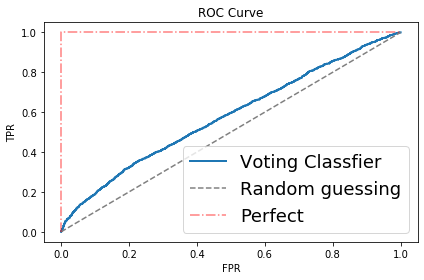



[classfier = pipe2]
Misclassified samples: 2432
Accuracy: 0.5601
scores: 0.639 (+/-0.010)
Test AUC: 0.5836


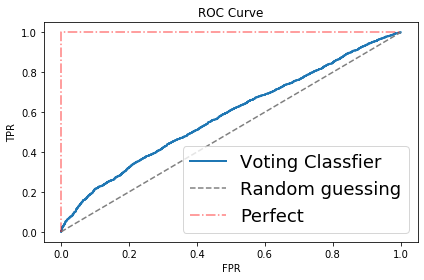



[classfier = pipe3]
Misclassified samples: 2445
Accuracy: 0.5578
scores: 0.626 (+/-0.012)
Test AUC: 0.5678


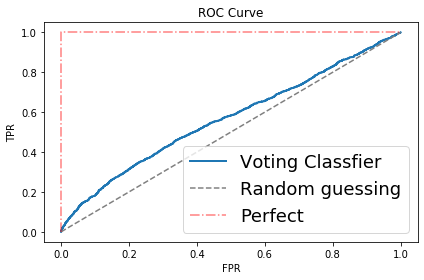



[classfier = pipe4]
Misclassified samples: 2435
Accuracy: 0.5596
scores: 0.642 (+/-0.011)
Test AUC: 0.5827


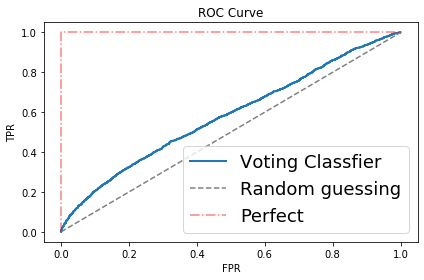



[classfier = pipe5]
Misclassified samples: 2433
Accuracy: 0.5600
scores: 0.642 (+/-0.011)
Test AUC: 0.5826


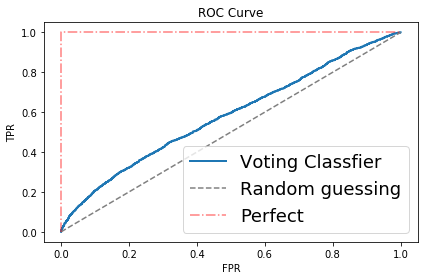



[classfier = pipe6]
Misclassified samples: 2450
Accuracy: 0.5569
scores: 0.636 (+/-0.010)
Test AUC: 0.5803


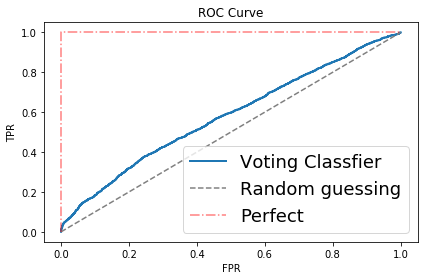



[classfier = pipe7]
Misclassified samples: 2444
Accuracy: 0.5580
scores: 0.638 (+/-0.010)
Test AUC: 0.5804


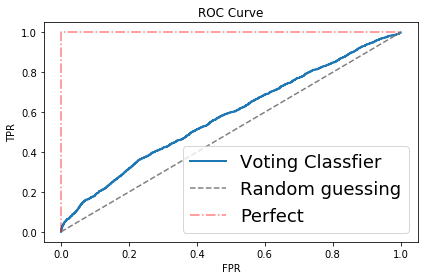

In [12]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
pipe1 = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_estimators=500, max_depth=15, n_jobs=-1, random_state=1))
                ])
pipe2 = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=1))
                ])
# channel,fig_count, link_count, weekday
pipe3 = Pipeline([
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_estimators=500, max_depth=1, n_jobs=-1, random_state=1))
                ])
pipe4 = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_estimators=1000, max_depth=10, n_jobs=-1, random_state=1))
                ])
pipe5 = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_estimators=800, max_depth=10, n_jobs=-1, random_state=1))
                ])
pipe6 = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', GradientBoostingClassifier(n_estimators=600))
                ])
pipe7 = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', GradientBoostingClassifier(n_estimators=500))
                ])

print("[=======testing different model========]")

names = ['pipe1','pipe2','pipe3','pipe4','pipe5','pipe6','pipe7']
print('[auc (10-fold cv)]')
best_clf , best_sc = None, -1
for name, clf in zip(names, [pipe1, pipe2, pipe3, pipe4, pipe5, pipe6, pipe7]):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train,
                         cv=10, scoring='roc_auc')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test,
                                 prob[:, 1],
                                pos_label=1)
    print("\n\n[classfier = %s]" % name)
    print('Misclassified samples: %d' % ((y_test != y_pred).sum()))
    print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
    print('scores: %.3f (+/-%.3f)' % (scores.mean(), scores.std()))
    print('Test AUC: %.4f' % auc(fpr, tpr))
    

    plt.plot(fpr, tpr, lw=2,
             label='Voting Classfier')

    plt.plot([0, 1],
             [0, 1],
             linestyle='--',
             color='gray',
             label='Random guessing')

    plt.plot([0, 0, 1],
             [0, 1, 1],
             linestyle='-.',
             alpha=0.5,
             color='red',
             label='Perfect')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.legend(loc=4, prop={'size': 18})
    plt.show()
    
    # avoid train model's score is overfitting ,so choose best test auc instead XD
    if best_sc < auc(fpr, tpr):
        best_clf, best_sc = clf, auc(fpr, tpr)

Misclassified samples: 2432
Accuracy: 0.5601


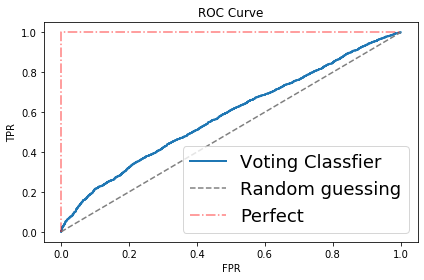

AUC: 0.5836


In [13]:
import matplotlib.pyplot as plt
proba = best_clf.predict_proba(X_test)
y_pred = best_clf.predict(X_test)
print('Misclassified samples: %d' % ((y_test != y_pred).sum()))
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
## we use feature 1 as positive label
fpr, tpr, thresholds = roc_curve(y_test,
                                 proba[:, 1],
                                pos_label=1)

plt.plot(fpr, tpr, lw=2,
         label='Voting Classfier')
    
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color='gray',
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle='-.',
         alpha=0.5,
         color='red',
         label='Perfect')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.legend(loc=4, prop={'size': 18})
plt.show()
print('AUC: %.4f' % auc(fpr, tpr))

In [14]:
df_real = pd.read_csv('./dataset/test.csv')

test_data = pd.DataFrame(columns=["title", "content", "tag", "channel", 
                                  "fig_count", "link_count", "weekday","timestamp", "section", "month", "day", "hour", "title_emotion"])
pgbar = progressbar.ProgressBar(widgets=['Progress: ',progressbar.Percentage(), ' ', progressbar.Bar('#'), progressbar.ETA()])
for i in pgbar(range(len(df_real))):
    title, content, tag, channel,  fig_count, link_count, weekday, timestamp, section, month, day, hour, title_emotion = data_preprocess(df_real.loc[i,'Page content'])
    test_data = test_data.append({ 
                                    "title": title, 
                                    "content": content,
                                    "tag":  tag,
                                    "channel": channel, 
                                    "fig_count":  fig_count,
                                    "link_count":  link_count,
                                    "weekday":  weekday,
                                    "timestamp":  timestamp,
                                    "section": section,
                                    "month": month, 
                                    "day": day,
                                    "hour": hour,
                                    "title_emotion": title_emotion
                                    }, ignore_index=True)
    
test_data.head()



Progress: 100% |#################################################|Time: 0:02:39


,title,content,tag,channel,fig_count,link_count,weekday,timestamp,section,month,day,hour,title_emotion
0,Soccer Star Gets Twitter Death Threats After T...,Note to humanity: One Direction fandom ai...,Entertainment Music One Direction soccer Sports,entertainment,1,30,1,1.378756e+09,23,9,9,19,0.0
1,Google Glass Gets an Accessory Store,Shortly after announcing a hardware upgrade f...,Gadgets glass Google Google Glass Google Glass...,tech,3,13,1,1.383212e+09,5,10,31,9,0.0
2,OUYA Gaming Console Already Sold Out on Amazon,"Well, that was quick. Just hours after going ...",amazon amazon kindle Business Gaming,business,2,13,1,1.372165e+09,7,6,25,12,0.0
3,'Between Two Ferns' Mocks Oscar Nominees,Between Two Ferns: Oscar Buzz Edition Part 1...,Between Two Ferns Movies The Oscars Oscars 201...,film,1,15,1,1.360726e+09,6,2,13,3,0.0
4,'American Sniper' Trailer: Looks Like Eastwood...,Ever since The Hurt Locker it seems like ...,American Sniper Awards Bradley Cooper clint ea...,entertainment,1,10,1,1.412300e+09,1,10,3,1,0.0


In [15]:
label_le = LabelEncoder()
test_data["channel"] = label_le.fit_transform(test_data["channel"].values)
test_data = cross_feature(test_data, "channel", "month", "channel_month")
test_data = cross_feature(test_data, "channel", "day", "channel_day")
test_data = cross_feature(test_data, "channel", "hour", "channel_hour")
test_data = test_data.drop(columns=['channel'])

In [16]:
# test_data = test_data[:]
# print( test_data)
names = ['title','content','tag']
for name, clf in zip(names, [pipe_title, pipe_content, pipe_tag]):
    clf.fit(tmp_X, tmp_y)
    test_data[name] = clf.predict_proba(test_data)

test_data = test_data.drop(columns=['content'])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [17]:
result = best_clf.predict_proba(test_data)
out = pd.DataFrame({ 'Id': df_real.Id,'Popularity': result[:, 1]})
out.to_csv('./y_pred_h.csv', index=False)

ValueError: X has 14 features, but this StandardScaler is expecting 15 features as input.

In [ ]:
X_train

In [ ]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf

def backwardElimination(x, y, sl, feature_num, select_method):
    columns = x.columns[np.full((x.shape[1],), True, dtype=bool)]
    x_value = x.values
    y_value = y.values
    numVars = len(x_value[0])
    
    if select_method == 0:
        for i in range(0, numVars):
            regressor_OLS = sm.OLS(y_value, x_value).fit()
            maxVar = max(regressor_OLS.pvalues).astype(float)
            if maxVar > sl:
                for j in range(0, numVars - i):
                    if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                        #print("deleted columns = {}, p-value = {}".format(columns[j], maxVar))
                        x_value = np.delete(x_value, j, 1)
                        columns = np.delete(columns, j)
    elif select_method == 1:
        for i in range(0, numVars - feature_num):
            regressor_OLS = sm.OLS(y_value, x_value).fit()
            maxVar = max(regressor_OLS.pvalues).astype(float)
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    #print("deleted columns = {}, p-value = {}".format(columns[j], maxVar))
                    x_value = np.delete(x_value, j, 1)
                    columns = np.delete(columns, j)
                
    return x_value, columns

In [ ]:
best_sc = 0
for i in range(1, 15):
    data_modeled, selected_columns = backwardElimination(X_train.apply(pd.to_numeric), y_train.astype('int'), 0, feature_num = i, select_method = 1)
    data_processed = X_train[selected_columns]
    for clf in [pipe1, pipe2, pipe3, pipe4, pipe5, pipe6, pipe7]:
        clf.fit(data_processed, y_train)
        prob = clf.predict_proba(X_test[selected_columns])
        fpr, tpr, thresholds = roc_curve(y_test,
                                     prob[:, 1],
                                    pos_label=1)
        if best_sc < auc(fpr, tpr):
            best_sc = auc(fpr, tpr)
            best_clf = clf
            best_columns = selected_columns
            print("best_sc = %.4f" % best_sc)
            print("selected_columns = ", selected_columns)

In [ ]:
best_clf.fit(X_train[best_columns], y_train)
prob = best_clf.predict_proba(X_test[best_columns])
fpr, tpr, thresholds = roc_curve(y_test,
                             prob[:, 1],
                            pos_label=1)
print("best_sc = %.4f" % auc(fpr, tpr))